In [24]:
import pathlib
import pandas as pd
from scipy import sparse
from sklearn.preprocessing import normalize
import numpy as np
import pickle
from itertools import islice
import gzip
from prompter import Prompter
from chromadb.utils.embedding_functions import OllamaEmbeddingFunction
import chromadb

In [25]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [227]:
def get_doc_top_tpcs(doc_distr, topn=2):
    sorted_tpc_indices = np.argsort(doc_distr)[::-1]
    top = sorted_tpc_indices[:topn].tolist()
    top_weight = [(k, doc_distr[k]) for k in top]
    return top_weight

def get_doc_main_topc(doc_distr):
    sorted_tpc_indices = np.argsort(doc_distr)[::-1]
    top = sorted_tpc_indices[:1][0]
    return top

In [228]:
def thrFig(
        thetas32,
        topics=None,
        max_docs=1000,
        poly_degree=3,
        smoothing_window=5,
        do_knee=True,
        n_steps=1000,
        figsize=(10, 6),
        fontsize=12,
        output_fpath=None,
    ):
    significant_docs = {}
    all_elbows = []
    
    # use colorbrewer Set2 colors
    colors = plt.cm.Dark2(np.linspace(0, 1, thetas32.shape[1]))
    n_docs = thetas32.shape[0]
    print(max_docs)
    max_docs = n_docs
    plt.figure(figsize=figsize)

    lines = []
    for k in range(len(thetas32.T)):
        theta_k = np.sort(thetas32[:, k])
        theta_over_th = theta_k[-max_docs:]
        step = max(1, int(np.round(len(theta_over_th) / n_steps)))
        y_values = theta_over_th[::step]
        x_values = np.arange(n_docs-max_docs, n_docs)[::step]

        # Apply smoothing
        x_values_smooth = uniform_filter1d(x_values, size=smoothing_window)

        label = None
        if topics is not None:
            label = topics[k]
        line, = plt.plot(x_values_smooth, y_values, color=colors[k], label=label)
        lines.append(line)
        
        if do_knee:
            # Using KneeLocator to find the elbow point
            allvalues = np.sort(thetas32[:, k].flatten())
            step = int(np.round(len(allvalues) / 1000))
            theta_values = allvalues[::step]
            idx_values = (100 / len(allvalues)) * np.arange(0, len(allvalues))[::step]
            
            # Apply smoothing
            idx_values_smooth = uniform_filter1d(idx_values, size=smoothing_window)

            kneedle = KneeLocator(theta_values, idx_values_smooth, curve='concave', direction='increasing', interp_method='polynomial', polynomial_degree=poly_degree)
            elbow = kneedle.elbow
            if elbow is not None:
                all_elbows.append(elbow)

                # Filter document indices based on the elbow point (keeping values above the elbow)
                significant_docs[k] = np.where(thetas32[:, k] >= elbow)[0]

        if elbow:
            # plot elbow in same color, smaller linewidth
            plt.plot([n_docs - max_docs, n_docs], [elbow, elbow], color=colors[k], linestyle='--', linewidth=1)

    # add legend where this series is named with the kth topic, do not assign to the 
    # elbow line
    if topics is not None:
        plt.legend(handles=lines, loc='upper left', fontsize=fontsize-1)

    # Add axis labels
    plt.xlabel('Document Index', fontsize=fontsize)
    plt.ylabel('Theta — P(k | d)', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)

    if output_fpath:
        # make bounding box extremely tight
        plt.savefig(output_fpath, bbox_inches='tight', pad_inches=0)

    plt.show()

    return significant_docs, all_elbows

In [229]:
path_source = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/data/source/corpus_rosie/passages/29_dec/all/df_1.parquet")
path_model = pathlib.Path("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/data/models/29_dec/all/poly_rosie_1_10")

In [230]:
raw = pd.read_parquet(path_source)

In [231]:
with open(path_model / "mallet_output" / "keys_EN.txt", 'r') as file:
    lines = file.readlines()
topic_keys = [line.strip() for line in lines]
topic_keys

['provider doctor care treatment technology health symptom medicine medication baby pregnancy medical treat birth woman child day time risk',
 'health hospital center national children medical pediatric care university medicine department program review clinical clinic american patient institute school',
 'child technology family health learn support organization start parent time activity care people school life physical program feel head',
 'infection vaccine health report person patient disease virus organization hiv vaccination outbreak risk influenza dose tuberculosis cdc laboratory testing',
 'age health report datum rate study increase death risk population organization woman adult factor student prevalence survey estimate level',
 'cancer patient doctor clinic treatment mayo surgery therapy tumor condition transplant clinical breast care study disease treat medical radiation',
 'food cell blood technology body gene level eat protein syndrome acid people genetic lead diet disord

In [214]:
thetas = sparse.load_npz(path_model / "mallet_output" / "thetas_EN.npz").toarray()
S3 = sparse.load_npz(path_model / "mallet_output" / "s3_EN.npz").toarray()

1000


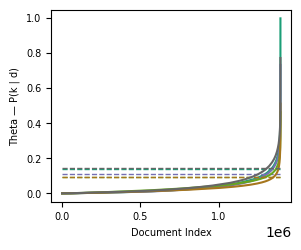

In [216]:
significant_docs, elbows = thrFig(
    S3,#[:, topics],
    #topics=kept_topics,
    max_docs=1000,
    do_knee=True,
    n_steps=5_000,
    figsize=(3.1, 2.5),
    fontsize=7,
    #output_fpath="../figures/thetas_mallet.pdf",
)

In [222]:
raw_en = raw[raw.doc_id.str.contains("EN")].copy()  

raw_en["thetas"] = list(thetas)
raw_en["s3"] = list(S3)
raw_en["top_k"] = raw_en["thetas"].apply(get_doc_top_tpcs)
raw_en["main_topic"] = raw_en["thetas"].apply(get_doc_main_topc)
raw_en["s3_main_topic"] = raw_en.apply(lambda x: x["s3"][x["main_topic"]], axis=1)
raw_en["s3_keep_doc"] = raw_en.apply(lambda x: x["s3_main_topic"] > 0.1* elbows[x["main_topic"]], axis=1)

In [225]:
raw_en[raw_en.s3_keep_doc == False][["text", "top_k", "main_topic", "s3_main_topic", "s3_keep_doc"]].head(50)

,text,top_k,main_topic,s3_main_topic,s3_keep_doc
1,"Author Affiliations: Shinyi Wu, PhD, University of Southern California and RAND Corporation, Los Angeles, California; Paul Di Capua, MD, MBA, University of California, Los Angeles, Los Angeles, California.","[(1, 0.9583333313154677), (0, 0.04166666868453228)]",1,0.005550,False
2,"Reviewed on Feb 24, 2023: He is a very good doctor.","[(1, 0.4999999925494195), (2, 0.16666666915019349)]",1,0.000000,False
12,You need more drugs or alcohol to get the same good feeling as when you first started using them.,"[(2, 0.44444444113307535), (4, 0.33333333830038697)]",2,0.006969,False
26,"Learn more about the effects of bullying, what adults can do to help prevent bullying, and where to find additional resourcesexternal icon.","[(4, 0.47058823354103985), (0, 0.41176470807370014)]",4,0.009274,False
38,"Poncz M, Cohen A, Schwartz E. Thalassemia, in Advances in Pediatrics, Barness L, editor, Yearbook Medical Publishers, Chicago, 1984.","[(1, 0.6250000046566129), (0, 0.29166665890564514)]",1,0.001057,False
44,The nutritional facts listed below are based on 1 serving size.,"[(3, 0.24999999627470976), (0, 0.24999999627470976)]",3,0.001394,False
50,"When a liver became available – for both women – in July 2020, they were thrilled to learn from their transplant coordinator, Cassandra Bray, they would be sharing the organ with another recipient.","[(0, 0.44000000089406965), (3, 0.28000000327825547)]",0,0.007789,False
57,"Depending on resource and staffing levels, dedicated cleaning staff posted at shared toilets in healthcare facilities could reduce risk associated with these areas.","[(0, 0.6551724100678131), (2, 0.17241379682873859)]",0,0.014014,False
58,"Gyan Pareek, MD, FACS, Named Chief of Urology: Urologist Gyan Pareek, MD, FACS, has been named chief of the division of urology and Krishnamurthi Family Professor of Urology at Brown University and president of Brown Urology, Inc.","[(0, 0.9090909090909091), (1, 0.045454545454545456)]",0,0.010793,False
65,"I hereby give, devise and bequeath _________ and No/100 dollars ($DOLLARS) to Bradley Hospital Foundation located in East Providence, RI, income and principal to be applied in its discretion for its general uses and purposes.","[(0, 0.9032258064516129), (4, 0.03225806451612903)]",0,0.002052,False


In [220]:
elbows

[0.14060196628885707,
 0.11244917566717394,
 0.09553168704283169,
 0.09141346463990722,
 0.14524202273159562]

In [26]:
indices_path = "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/indices"
client = chromadb.PersistentClient(path=indices_path)

In [27]:
df_en = pd.read_parquet("/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/df_en.parquet")
df_en.columns

Index(['id_top', 'doc_id', 'id_preproc', 'document_id', 'text', 'len',
       'full_doc', 'human_labeled', 'lemmas', 'lemmas_tr', 'text_tr', 'lang',
       'final_label', 'common_id', 'thetas', 's3', 'top_k', 'main_topic',
       's3_main_topic', 's3_keep_doc'],
      dtype='object')

In [28]:
df_en_tpc = df_en[df_en.main_topic == 0].copy()
df_en_tpc[["text", "top_k", "main_topic", "s3_main_topic", "s3_keep_doc"]]

,text,top_k,main_topic,s3_main_topic,s3_keep_doc
19,Prevention: Avoid or reduce the use of alcohol. Get prompt medical treatment for symptoms of alcohol withdrawal.,"[[0.0, 0.7272727272727273], [4.0, 0.09090909090909091]]",0,0.067057,True
21,"Results are considered “screen negative” if the risk for Down syndrome is less than one in 110 (for example, one in 150 or one in 200). Keep in mind that screening tests cannot diagnose or rule out specific conditions, only measure the chances of one affecting your baby.","[[0.0, 0.3103448198787096], [6.0, 0.27586207204851615]]",0,0.049260,True
23,"Healthcare providers, health plans, delivery systems, and information technologies all play a role in supporting children’s healthy growth and the prevention and treatment of obesity.","[[0.0, 0.28125], [7.0, 0.28125]]",0,0.092564,True
28,"If a male has Zika he can pass the virus to his partner through unprotected sex. This can increase the chance of birth defects in his partner’s pregnancy. Males who might have been exposed to Zika virus should use condoms and wait at least 3 months before trying to conceive a pregnancy, even if they do not have symptoms.","[[0.0, 0.47916666655025136], [3.0, 0.3541666639891142]]",0,0.099530,True
29,Wound care: Your healthcare provider will instruct you on how to clean and change your dressing daily.,"[[0.0, 0.5882352989386108], [8.0, 0.3529411734027022]]",0,0.030304,True
...,...,...,...,...,...
1393054,"Can you get pregnant after menopause: Once your menstrual period has been absent for over a year, you are unlikely to get pregnant. Until your healthcare provider has confirmed you are no longer ovulating and can’t get pregnant, continue to use birth control if you don't want to become pregnant.","[[0.0, 0.8611111076962616], [3.0, 0.08333333612730107]]",0,0.051973,True
1393075,"Follow-up: If your child has been seen at a hospital, they must have a follow-up appointment scheduled. Ask the health care provider working with your child to schedule a follow-up appointment.","[[0.0, 0.869565211560415], [7.0, 0.04347826281319499]]",0,0.145272,True
1393086,2. Check your child's blood pressure using standard testing equipment. Your child's hearing may be checked.,"[[0.0, 0.3999999985098839], [9.0, 0.19999999925494194]]",0,0.030845,True
1393089,"If that doesn’t work, what are the best treatments: Talk with your pediatrician first. For infants, breastfeeding gives protection against allergies. But there are some great over-the-counter treatments available for school age and older kids including nasal sprays like Flonase and Nasacort and antihistamines such as Claritin, Zyrtec, Allegra, etc.","[[0.0, 0.7173913054411178], [2.0, 0.13043478009817394]]",0,0.074275,True


In [51]:
collection = client.get_collection(name="docs_0_es")

In [62]:
template_path = "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/templates/1_instruction_prompt.txt"
system_template_path = "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/templates/1_system_prompt.txt"
llm_model = "llama3:70b-instruct" #"llama3:70b" # llama3.1:8b-instruct-q8_0
with open(template_path, 'r') as file:
    template = file.read()

In [66]:
question = template.format(passage=df_en.iloc[1].text, full_document=(df_en.iloc[1].full_doc[:500]+ " [...]"))
print(question)

System message:

Your input fields are:
1. `PASSAGE` (str)
2. `FULL_DOCUMENT` (str)

Your output fields are:
1. `reasoning` (str)
2. `QUESTIONS` (str): YES/NO questions separated by `\n`extracted from the provided `PASSAGE`, if the `PASSAGE` contains objective information that can be transformed into YES/NO questions. Otherwise, leave this field empty.

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## PASSAGE ## ]]
{PASSAGE}

[[ ## FULL_DOCUMENT ## ]]
{FULL_DOCUMENT}

[[ ## reasoning ## ]]
{reasoning}

[[ ## QUESTIONS ## ]]
{QUESTIONS}

[[ ## completed ## ]]

In adhering to this structure, your objective is:
    1. Determine whether the provided PASSAGE within the given context provides objective information that can be transformed into YES/NO questions. People experiences, opinions, or subjective information should not be used to generate questions.
    2. If the PASSAGE contains objective information, generate YES/NO questions fr

In [67]:
prompter = Prompter(
    model_type=llm_model,
)

questions, _ = prompter.prompt(
    system_prompt_template_path=system_template_path,
    question=question
)

Cache miss: computing results...


In [68]:
questions

'[[ ## reasoning ## ]]\nThe passage provides objective information about the affiliations of authors Shinyi Wu and Paul Di Capua.\n\n[[ ## QUESTIONS ## ]]\nIs Shinyi Wu affiliated with the University of Southern California?\\nIs Paul Di Capua affiliated with the University of California, Los Angeles?\\nDoes Shinyi Wu have a PhD degree?\n\n[[ ## completed ## ]]'

In [12]:
[el.strip() for el in questions.split("---") if len(el.strip()) > 1]

['Are children diagnosed with Multisystem Inflammatory Syndrome in Children (MIS-C) often between the ages of 5 and 11 years old?',
 'Can Multisystem Inflammatory Syndrome in Children (MIS-C) affect children as young as 1 year old?',
 'Have cases of Multisystem Inflammatory Syndrome in Children (MIS-C) been reported among older children and babies?',
 'Is Multisystem Inflammatory Syndrome in Children (MIS-C) a rare condition?',
 'Can Multisystem Inflammatory Syndrome in Children (MIS-C) lead to severe problems with vital organs, such as the heart?',
 'Does early diagnosis and treatment of Multisystem Inflammatory Syndrome in Children (MIS-C) prevent permanent damage or death?',
 'Are COVID-19 vaccines effective in preventing Multisystem Inflammatory Syndrome in Children (MIS-C)?',
 'Can following precautions such as handwashing, social distancing, and wearing masks help prevent the spread of COVID-19 and Multisystem Inflammatory Syndrome in Children (MIS-C)?',
 'Is it possible for chil

In [ ]:
"""
from sklearn.svm import OneClassSVM
from sentence_transformers import SentenceTransformer

trf_model = SentenceTransformer('all-MiniLM-L6-v2')

path_tr_data="/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/src/qa_system/tr_data/questions_rosie/FullTrialQa7152024.csv"
df_positive = pd.read_csv(path_tr_data)
df_filtered = df_positive.dropna(
    subset=['question', 'answerPassageText'])
positive_questions = list(
    set(df_filtered[['question', 'answerPassageText']].question.values.tolist()))

ocsvm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.1)
ocsvm.fit(trf_model.encode(positive_questions))
"""

In [ ]:
for question in [el.strip() for el in questions.split("---") if len(el.strip()) > 1]:
    print(question, ocsvm.predict(trf_model.encode([question])))

In [14]:
LLM_MODEL_EMBEDDINGS = 'mxbai-embed-large:latest'
BATCH_SIZE = 512
EMBEDDING_URL = "http://kumo01.tsc.uc3m.es:11434/api/embeddings"

# Initialize embedding function
embedding_function = OllamaEmbeddingFunction(
    model_name=LLM_MODEL_EMBEDDINGS,
    url=EMBEDDING_URL,
)

In [15]:
embedding = embedding_function("Are children diagnosed with Multisystem Inflammatory Syndrome in Children (MIS-C) often between the ages of 5 and 11 years old?")[0]
print(type(embedding))
print(embedding)

results = collection.query(
    query_embeddings=[embedding.tolist()],  # Convert the numpy array to a Python list and wrap in a list
    n_results=6
)
results

<class 'numpy.ndarray'>
[0.14232633 1.1843396  0.24204206 ... 0.18227723 0.8108455  0.04077638]


{'ids': [['1062876', '425083', '1007652', '204490', '74479', '634694']],
 'embeddings': None,
 'documents': [['A algunos padres les incomoda la idea de recibir un informe escolar del IMC de sus hijos. Pero los niños con sobrepeso tienen más probabilidades de desarrollar problemas de salud, como la hipertensión (tensión arterial alta) y la diabetes. Los padres deben compartir el informe escolar del IMC con el médico de sus hijos, quien les puede ayudar a interpretar los resultados y darles recomendaciones.',
   'Síntomas: Los niños tienen más probabilidades que los adultos de presentar síntomas de una infección por E. coli. La mayoría de las personas con la infección tendrán:',
   '¿Cuáles son los síntomas de la faringitis y la amigdalitis en los niños: Los síntomas pueden presentarse de forma un poco diferente en cada niño. Pueden incluir los siguientes:',
   '¿Cuáles son los síntomas de la endocarditis bacteriana en los niños: Los síntomas pueden presentarse de forma un poco diferente

In [16]:
import spacy

# Load a pre-trained spaCy model
# Here, we use the English model `en_core_web_sm`
nlp = spacy.load("en_core_web_sm")

# Example text
text = "Are children diagnosed with Multisystem Inflammatory Syndrome in Children (MIS-C) often between the ages of 5 and 11 years old?"

# Process the text with the spaCy model
doc = nlp(text)

# Extract entities
print("Entities detected:")
for ent in doc.ents:
    print(f"Text: {ent.text}, Label: {ent.label_}")

# Optional: Print entity explanations
print("\nEntity label explanations:")
for ent in doc.ents:
    print(f"{ent.label_}: {spacy.explain(ent.label_)}")


/home/lbartolome/.local/lib/python3.10/site-packages/langchain_community/llms/__init__.py:28: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_community.llms.ai21 import AI21


PydanticUserError: The `__modify_schema__` method is not supported in Pydantic v2. Use `__get_pydantic_json_schema__` instead in class `SecretStr`.

For further information visit https://errors.pydantic.dev/2.9/u/custom-json-schema